In [1]:
import os
import cv2
import csv
import numpy as np
from time import time
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG19
import matplotlib.pyplot as plt

In [2]:
def preprocess(image, out_side):
    height, width = image.shape[:2]
    scale = out_side / max(height, width)
    dx = (out_side - scale * width) / 2
    dy = (out_side - scale * height) / 2
    trans = np.array([[scale, 0, dx], [0, scale, dy]], dtype=np.float32)
    image = cv2.warpAffine(image, trans, (out_side, out_side), flags=cv2.INTER_AREA)
    image = cv2.resize(image, (out_side, out_side))
    return image

def mixing(images, labels):
    images = np.array(images)
    labels = np.array(labels)
    s = np.arange(images.shape[0])
    np.random.seed(43)
    np.random.shuffle(s)
    images=images[s]
    labels=labels[s]
    return images, labels
def load_train(path, out_side):
    images = []
    labels = []
    for folder in os.listdir(os.path.join(path, 'Train')):
        cur_path = os.path.join(path, 'Train', folder)
        for file_name in os.listdir(cur_path):
            image = cv2.imread(os.path.join(cur_path, file_name))
            images.append(preprocess(image, out_side))
            labels.append(int(folder))

    return mixing(images, labels)
def load_test(path, out_side):
    images = []
    labels = []
    with open(os.path.join(path, 'Test.csv'), 'r') as f:
        reader = csv.reader(f)
        for rows in reader:
            name = rows[7]
            if (name == 'Path'):
                continue
            image = cv2.imread(os.path.join(path, rows[7]))
            images.append(preprocess(image, out_side))
            labels.append(int(rows[6]))

    return mixing(images, labels)

In [3]:
dir='D:\DL dataset 2'
start = time()

train_images, train_labels = load_train(dir + "/", 50)
test_images, test_labels = load_test(dir + "/", 50)
shape = train_images[0].shape
print(shape)

train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

train_labels = utils.to_categorical(train_labels, 43)
test_labels = utils.to_categorical(test_labels, 43)

print('Loading: ', time() - start)

(50, 50, 3)
Loading:  539.61088347435


In [6]:
classes = 43
batch = 32
epochs = 10
learning_rate = 0.0001

def results(model):
  adam = Adam(lr=learning_rate)

  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

  start = time()
  history = model.fit(train_images, train_labels, batch_size=batch, epochs=epochs, validation_split=0.2, shuffle = True, verbose=1)
  train_time = time() - start
  model.summary()
  
  plt.figure(figsize=(12, 12))
  plt.subplot(3, 2, 1)
  plt.plot(history.history['accuracy'], label = 'train_accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.subplot(3, 2, 2)
  plt.plot(history.history['loss'], label = 'train_loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')0
  plt.legend()
  plt.show()

  start = time()
  test_loss, test_acc = model.evaluate(test_images, test_labels)
  test_time = time() - start
  print('\nTrain time: ', train_time)
  print('Test accuracy:', test_acc)
  print('Test loss:', test_loss)
  print('Test time: ', test_time)

Epoch 1/10
981/981 [==============================] - 2243s 2s/step - loss: 2.0382 - accuracy: 0.3771 - val_loss: 1.0731 - val_accuracy: 0.6440
Epoch 2/10
981/981 [==============================] - 2205s 2s/step - loss: 0.5710 - accuracy: 0.8185 - val_loss: 0.5234 - val_accuracy: 0.8401
Epoch 3/10
981/981 [==============================] - 2146s 2s/step - loss: 0.2202 - accuracy: 0.9319 - val_loss: 0.5790 - val_accuracy: 0.8240
Epoch 4/10
981/981 [==============================] - 2183s 2s/step - loss: 0.1326 - accuracy: 0.9599 - val_loss: 0.1261 - val_accuracy: 0.9651
Epoch 5/10
981/981 [==============================] - 2261s 2s/step - loss: 0.1076 - accuracy: 0.9677 - val_loss: 0.2509 - val_accuracy: 0.9490
Epoch 6/10
981/981 [==============================] - 2657s 3s/step - loss: 0.0945 - accuracy: 0.9713 - val_loss: 0.4384 - val_accuracy: 0.8991
Epoch 7/10
981/981 [==============================] - 3125s 3s/step - loss: 0.0706 - accuracy: 0.9795 - val_loss: 0.1744 - val_accuracy:

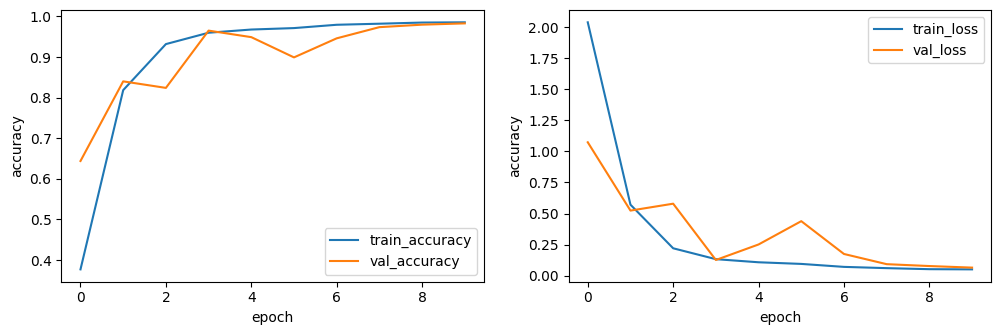

395/395 [==============================] - 179s 453ms/step - loss: 0.2638 - accuracy: 0.9411

Train time:  24091.94038438797
Test accuracy: 0.9410926103591919
Test loss: 0.263772577047348
Test time:  178.93848586082458


In [7]:
model = Sequential()
model.add(VGG19(weights='imagenet', include_top=False, input_shape=(50,50,3)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1024, activation='sigmoid'))
model.add(Dense(43, activation='softmax'))

results(model)

In [19]:
import tensorflow as tf
ima=image = cv2.imread("D:\DL dataset 2\Train\\14\\00014_00001_00026.png")
input_array = np.array(ima)
print(input_array.shape)
# Add an extra dimension to the array
output_array = np.expand_dims(input_array, axis=2)

print(output_array.shape)

# Repeat the added dimension to match the desired shape
output_array = np.repeat(output_array, 50, axis=2)
output_array.resize(output_array,(50,50,3))
print(output_array.shape)
# Convert the array back to a tensor
output_tensor = tf.convert_to_tensor(output_array)
output_tensor
# model.predict(preprocess(output_tensor,50))

(144, 144, 3)
(144, 144, 1, 3)


TypeError: only integer scalar arrays can be converted to a scalar index

In [8]:
model.save('pretrained3.h5')